In [2]:
import numpy as np
import itertools
import time
import random
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

In [3]:
attributes = {
    'color': ['red', 'green', 'blue'],
    'fill': ['void', 'dashed', 'solid'],
    'shape': ['square', 'circle', 'triangle'],
    'config': ['XXO', 'XOX', 'OXX']
}

In [54]:
2**81

2417851639229258349412352

In [4]:
def generate_cards(attributes, attr_order):
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}
    attrs_to_idx = defaultdict(lambda: defaultdict(list))

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
        for attr_val, attr_typ in zip(combo, attr_order):
            attrs_to_idx[attr_typ][attr_val].append(i)
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx, attrs_to_idx


cards, idx_to_card, card_to_idx, attrs_to_idx = generate_cards(attributes, attr_order=('color', 'fill', 'shape', 'config'))
cards[:5]

Generated 81 unqiue cards


[('red', 'void', 'square', 'XXO'),
 ('red', 'void', 'square', 'XOX'),
 ('red', 'void', 'square', 'OXX'),
 ('red', 'void', 'circle', 'XXO'),
 ('red', 'void', 'circle', 'XOX')]

In [6]:
def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    for card1, card2 in itertools.product(cards, cards):
        if card1 != card2:
            matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
            if set(matching_concepts) != {'-'}:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'Generated {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair

cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = generate_card_pairs(cards, card_to_idx)
print()
sampids = np.random.choice(len(cardpairs_with_shared_concepts), size=5)
print('cardpairs with shared concepts\n', [cardpairs_with_shared_concepts[i] for i in sampids])
print()
sampids = np.random.choice(len(cardpairs_without_shared_concepts), size=5)
print('cardpairs without shared concepts\n', [cardpairs_without_shared_concepts[i] for i in sampids])

Generated 5184 cardpairs with shared concept
Generated 1296 cardpairs without shared concept

cardpairs with shared concepts
 [((54, 76), ('blue', '-', '-', '-')), ((44, 43), ('green', 'dashed', 'triangle', '-')), ((49, 25), ('-', 'solid', '-', 'XOX')), ((19, 16), ('red', '-', '-', 'XOX')), ((56, 60), ('blue', 'void', '-', '-'))]

cardpairs without shared concepts
 [((78, 5), ('-', '-', '-', '-')), ((59, 52), ('-', '-', '-', '-')), ((20, 42), ('-', '-', '-', '-')), ((72, 14), ('-', '-', '-', '-')), ((7, 65), ('-', '-', '-', '-'))]


In [7]:
def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches. Identify nonConcepts and violatedConcepts
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = True
    for ct, cd in zip(concept, card):
        if ct != '-' and cd != ct:
            match = False
    return match

In [8]:
def gen_card_data(attributes, attr_order, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx, attrs_to_idx = generate_cards(attributes, attr_order)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        matching_cards = [(cardpair[0], card_to_idx[card]) for card in cards if match_concept_to_card(shared_concept, card)]
        all_matches += matching_cards
    print('Total number of matches = ', len(all_matches))
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_card': idx_to_card,
        'card_to_idx': card_to_idx,
        'attrs_to_idx': attrs_to_idx,
        'cardpair_to_idx': cardpair_to_idx, 
        'idx_to_cardpair': idx_to_cardpair,
        'all_matches': all_matches,
        'unseen_cardpair_indices': unseen_cardpair_indices,
        'train_cardpair_indices': train_cardpair_indices
    }
    return data
    

In [9]:
attributes = {
    'color': ['red', 'green', 'blue'],
    'fill': ['void', 'dashed', 'solid'],
    'shape': ['square', 'circle', 'triangle'],
    'config': ['XXO', 'XOX', 'OXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

data = gen_card_data(attributes, attr_order, num_unseen_cardpairs=100, debug=False)

Generated 81 unqiue cards
Generated 5184 cardpairs with shared concept
Generated 1296 cardpairs without shared concept
Total number of matches =  89424


In [21]:
# build the count tables

train_count_table = np.zeros((81, 6480))
for (cardpair, card) in data['all_matches']:
    if data['cardpair_to_idx'][cardpair] in data['train_cardpair_indices']:
        train_count_table[card, data['cardpair_to_idx'][cardpair]] += 1
        
unseen_count_table = np.zeros((81, 6480))
for (cardpair, card) in data['all_matches']:
    if data['cardpair_to_idx'][cardpair] in data['unseen_cardpair_indices']:
        unseen_count_table[card, data['cardpair_to_idx'][cardpair]] += 1

In [22]:
# build the total count table

count_table = np.zeros((81, 6480))
for (cardpair, card) in data['all_matches']:
    count_table[card, data['cardpair_to_idx'][cardpair]] += 1

xy = count_table/np.sum(count_table)
xy += 0.0000001
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

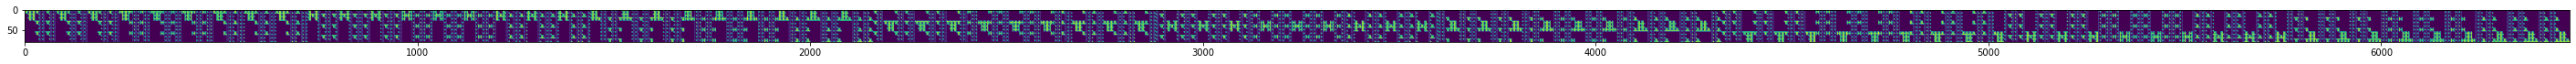

In [23]:
plt.figure(figsize = (50,10))
plt.imshow(xy)
plt.savefig(f"cardgame_jt.png")

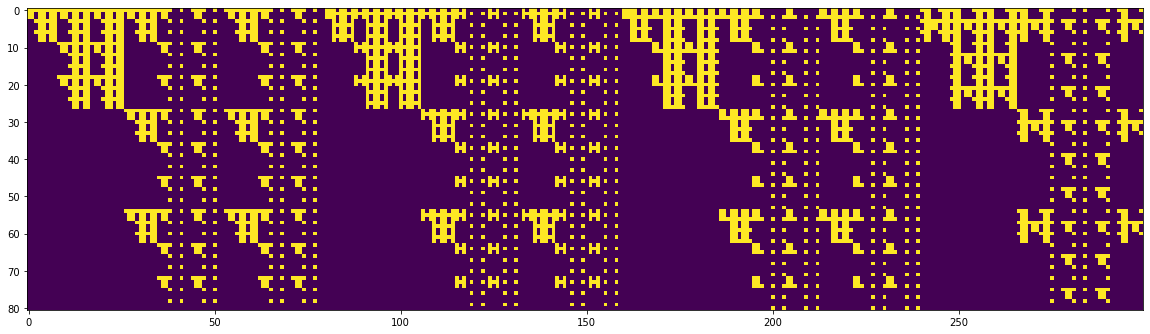

In [219]:
plt.figure(figsize = (20,100))
plt.imshow((xy)[:, :300])
plt.savefig(f"cardgame_pmi.png")

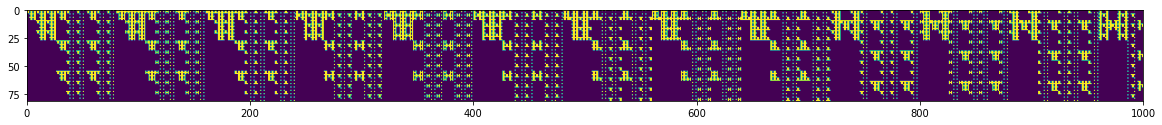

In [31]:
plt.figure(figsize = (20,100))
plt.imshow(xy[:, :1000], extent=[0,1000,81,0])
plt.savefig(f"cardgame_jt.png")

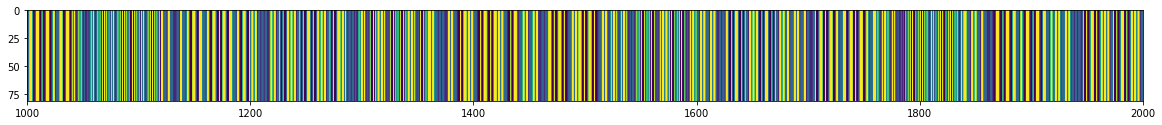

In [47]:
plt.figure(figsize = (20,100))
plt.imshow((xyind)[:, 1000:2000], extent=[1000,2000,81,0])
plt.savefig(f"cardgame_pmi.png")

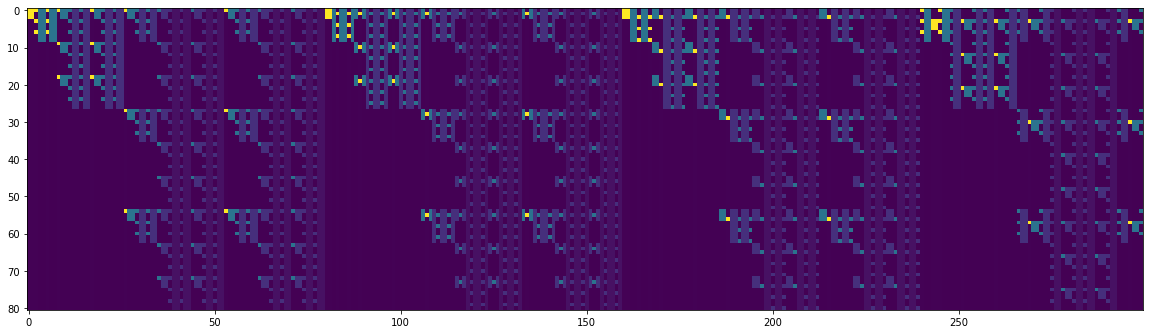

In [220]:
plt.figure(figsize = (20,100))
plt.imshow((xy/xyind)[:, :300])
plt.savefig(f"cardgame_pmi.png")